In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
CONFIG = {
    'img_size': 32,
    'patch_size': 4,
    'num_classes': 10,
    'dim': 384,
    'depth': 7,
    'heads': 6,
    'mlp_dim': 768,
    'dropout': 0.1,
    'batch_size': 128,
    'epochs': 200,
    'lr': 0.001,
}

In [3]:
# Training transforms (data augmentation for better accuracy)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),      # Random cropping
    transforms.RandomHorizontalFlip(),          # Flip images randomly
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),  # Advanced augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Test transforms (no augmentation, just normalize)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
# Download and load CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

trainloader = DataLoader(trainset, batch_size=CONFIG['batch_size'],
                         shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=CONFIG['batch_size'],
                        shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, dim):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.heads, C // self.heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x

In [7]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_dim, dropout):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, mlp_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [9]:
class VisionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbedding(
            config['img_size'],
            config['patch_size'],
            config['dim']
        )

        num_patches = self.patch_embed.num_patches

        # CLS token (learnable)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config['dim']))

        # Positional embeddings (learnable)
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, config['dim']))

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(
                config['dim'],
                config['heads'],
                config['mlp_dim'],
                config['dropout']
            ) for _ in range(config['depth'])
        ])

        # Final layer norm
        self.norm = nn.LayerNorm(config['dim'])

        # Classification head
        self.head = nn.Linear(config['dim'], config['num_classes'])

        # Dropout
        self.dropout = nn.Dropout(config['dropout'])

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)

        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)

        # Add positional embeddings
        x = x + self.pos_embed
        x = self.dropout(x)

        # Transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final norm
        x = self.norm(x)

        # Classification from CLS token
        x = x[:, 0]
        x = self.head(x)

        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer(CONFIG).to(device)


criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG['lr'], weight_decay=0.05)


scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

In [11]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(trainloader), 100. * correct / total

def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return 100. * correct / total

In [13]:
# Lists to store metrics for plotting
train_losses = []
train_accs = []
test_accs = []
epochs_list = []

best_acc = 0
start_time = time.time()

# Create figure for live plotting
plt.ion()  # Turn on interactive mode
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for epoch in range(80):
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer, device)
    test_acc = test(model, testloader, device)
    scheduler.step()

    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    epochs_list.append(epoch + 1)

    if test_acc > best_acc:
        best_acc = test_acc

    # Update plots every 5 epochs
    if (epoch + 1) % 5 == 0:
        clear_output(wait=True)

        # Plot 1: Loss
        ax1.clear()
        ax1.plot(epochs_list, train_losses, 'b-', linewidth=2, label='Train Loss')
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss', fontsize=12)
        ax1.set_title('Training Loss', fontsize=14, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()

        # Plot 2: Accuracy
        ax2.clear()
        ax2.plot(epochs_list, train_accs, 'g-', linewidth=2, label='Train Acc')
        ax2.plot(epochs_list, test_accs, 'r-', linewidth=2, label='Test Acc')
        ax2.axhline(y=best_acc, color='orange', linestyle='--',
                    linewidth=2, label=f'Best: {best_acc:.2f}%')
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy (%)', fontsize=12)
        ax2.set_title('Training & Test Accuracy', fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()

        plt.tight_layout()
        plt.draw()
        plt.pause(0.001)

        # Print progress
        elapsed = (time.time() - start_time) / 60
        print(f'Epoch {epoch+1}/80 | '
              f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}% | '
              f'Test Acc: {test_acc:.2f}% | Best: {best_acc:.2f}% | '
              f'Time: {elapsed:.1f}min')

plt.ioff()  # Turn off interactive mode
plt.show()

print(f'\nTraining Complete!')
print(f'Best Test Accuracy: {best_acc:.2f}%')
print(f'Total Time: {(time.time() - start_time) / 60:.1f} minutes')

<Figure size 640x480 with 0 Axes>

Epoch 80/80 | Train Loss: 1.277 | Train Acc: 54.15% | Test Acc: 63.40% | Best: 63.40% | Time: 100.5min

Training Complete!
Best Test Accuracy: 63.40%
Total Time: 100.5 minutes


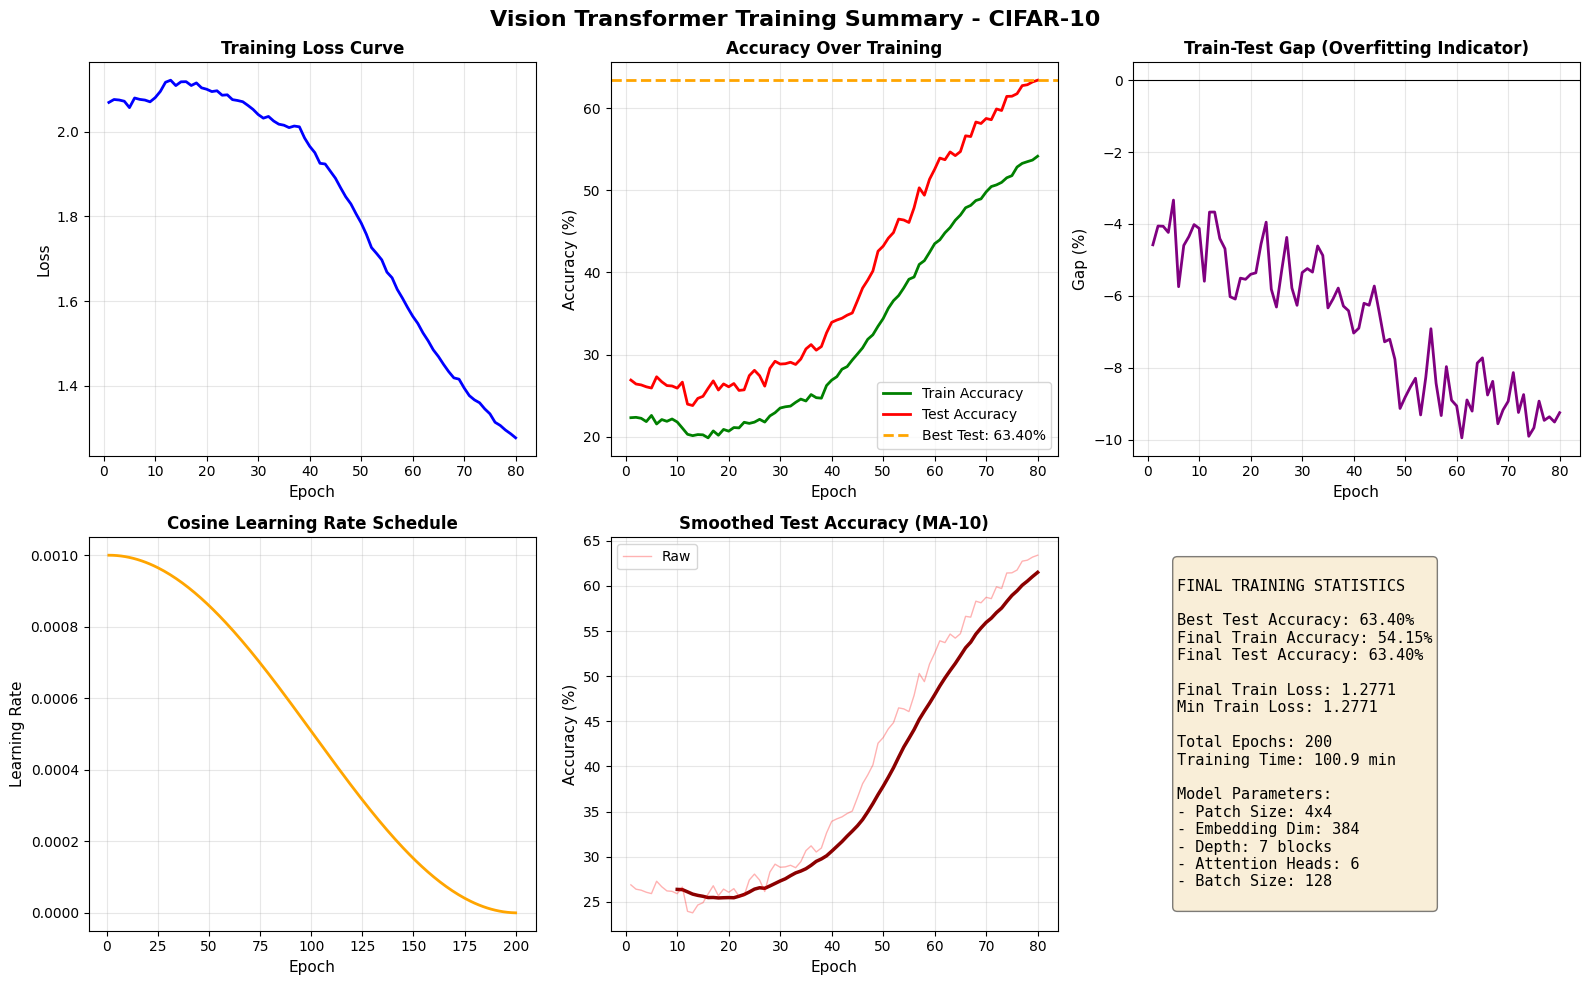

Graphs saved as 'training_results.png'


In [14]:
# Create comprehensive final visualization
fig = plt.figure(figsize=(16, 10))

# Plot 1: Training Loss Over Time
ax1 = plt.subplot(2, 3, 1)
ax1.plot(epochs_list, train_losses, 'b-', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=11)
ax1.set_ylabel('Loss', fontsize=11)
ax1.set_title('Training Loss Curve', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Accuracy Comparison
ax2 = plt.subplot(2, 3, 2)
ax2.plot(epochs_list, train_accs, 'g-', linewidth=2, label='Train Accuracy')
ax2.plot(epochs_list, test_accs, 'r-', linewidth=2, label='Test Accuracy')
ax2.axhline(y=best_acc, color='orange', linestyle='--', linewidth=2,
            label=f'Best Test: {best_acc:.2f}%')
ax2.set_xlabel('Epoch', fontsize=11)
ax2.set_ylabel('Accuracy (%)', fontsize=11)
ax2.set_title('Accuracy Over Training', fontsize=12, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

# Plot 3: Generalization Gap
ax3 = plt.subplot(2, 3, 3)
gap = [train - test for train, test in zip(train_accs, test_accs)]
ax3.plot(epochs_list, gap, 'purple', linewidth=2)
ax3.set_xlabel('Epoch', fontsize=11)
ax3.set_ylabel('Gap (%)', fontsize=11)
ax3.set_title('Train-Test Gap (Overfitting Indicator)', fontsize=12, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax3.grid(True, alpha=0.3)

# Plot 4: Learning Rate Schedule
ax4 = plt.subplot(2, 3, 4)
# Get learning rates from scheduler
lrs = [CONFIG['lr'] * (0.5 * (1 + np.cos(np.pi * epoch / CONFIG['epochs'])))
       for epoch in range(CONFIG['epochs'])]
ax4.plot(range(1, CONFIG['epochs'] + 1), lrs, 'orange', linewidth=2)
ax4.set_xlabel('Epoch', fontsize=11)
ax4.set_ylabel('Learning Rate', fontsize=11)
ax4.set_title('Cosine Learning Rate Schedule', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Plot 5: Smoothed Test Accuracy (Moving Average)
ax5 = plt.subplot(2, 3, 5)
window = 10
if len(test_accs) >= window:
    smoothed = np.convolve(test_accs, np.ones(window)/window, mode='valid')
    ax5.plot(range(window, len(test_accs) + 1), smoothed, 'darkred', linewidth=2.5)
    ax5.plot(epochs_list, test_accs, 'r-', alpha=0.3, linewidth=1, label='Raw')
else:
    ax5.plot(epochs_list, test_accs, 'r-', linewidth=2)
ax5.set_xlabel('Epoch', fontsize=11)
ax5.set_ylabel('Accuracy (%)', fontsize=11)
ax5.set_title('Smoothed Test Accuracy (MA-10)', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Plot 6: Final Statistics Box
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
stats_text = f'''
FINAL TRAINING STATISTICS

Best Test Accuracy: {best_acc:.2f}%
Final Train Accuracy: {train_accs[-1]:.2f}%
Final Test Accuracy: {test_accs[-1]:.2f}%

Final Train Loss: {train_losses[-1]:.4f}
Min Train Loss: {min(train_losses):.4f}

Total Epochs: {CONFIG['epochs']}
Training Time: {(time.time() - start_time) / 60:.1f} min

Model Parameters:
- Patch Size: {CONFIG['patch_size']}x{CONFIG['patch_size']}
- Embedding Dim: {CONFIG['dim']}
- Depth: {CONFIG['depth']} blocks
- Attention Heads: {CONFIG['heads']}
- Batch Size: {CONFIG['batch_size']}
'''
ax6.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
         verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Vision Transformer Training Summary - CIFAR-10',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("Graphs saved as 'training_results.png'")

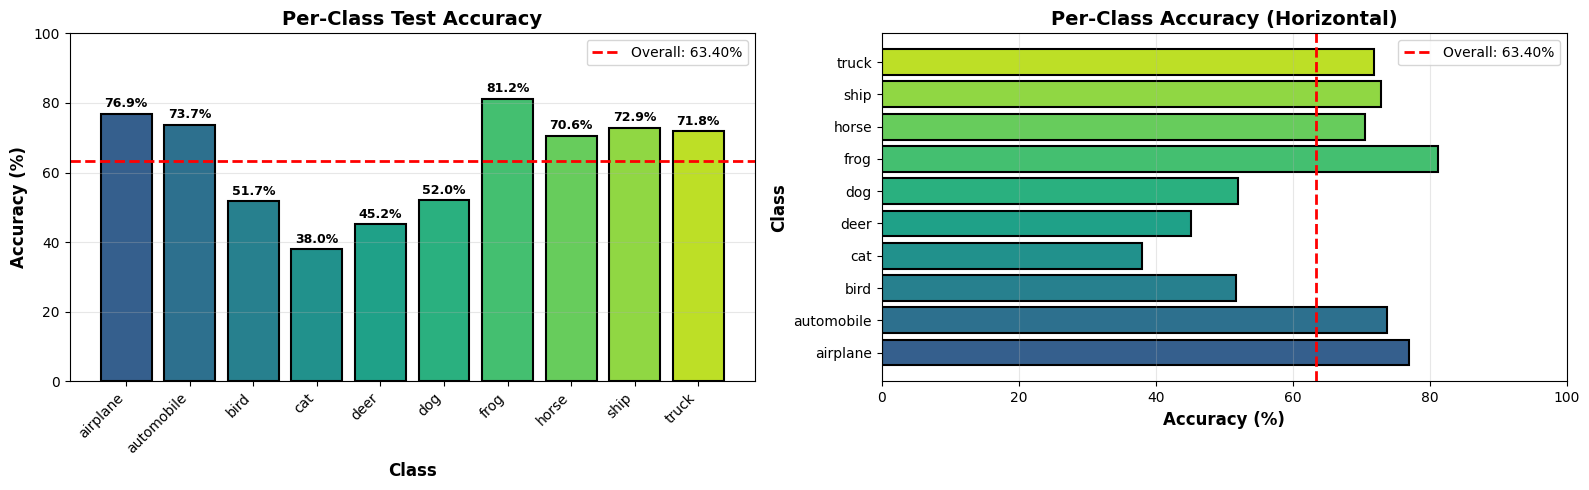


PER-CLASS ACCURACY BREAKDOWN
airplane    : 76.90% (769/1000)
automobile  : 73.70% (737/1000)
bird        : 51.70% (517/1000)
cat         : 38.00% (380/1000)
deer        : 45.20% (452/1000)
dog         : 52.00% (520/1000)
frog        : 81.20% (812/1000)
horse       : 70.60% (706/1000)
ship        : 72.90% (729/1000)
truck       : 71.80% (718/1000)
OVERALL     : 63.40%


In [15]:
# Evaluate per-class accuracy
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

class_correct = [0] * 10
class_total = [0] * 10

model.eval()
with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

class_accuracies = [100 * class_correct[i] / class_total[i] for i in range(10)]

# Plot per-class accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Bar plot
colors = plt.cm.viridis(np.linspace(0.3, 0.9, 10))
bars = ax1.bar(classes, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax1.axhline(y=best_acc, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {best_acc:.2f}%')
ax1.set_xlabel('Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Per-Class Test Accuracy', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 100])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels on bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Confusion-style heatmap data
ax2.barh(classes, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)
ax2.axvline(x=best_acc, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {best_acc:.2f}%')
ax2.set_xlabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Class', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class Accuracy (Horizontal)', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 100])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

# Print detailed results
print("\n" + "="*50)
print("PER-CLASS ACCURACY BREAKDOWN")
print("="*50)
for i, cls in enumerate(classes):
    print(f"{cls:12s}: {class_accuracies[i]:5.2f}% ({class_correct[i]}/{class_total[i]})")
print("="*50)
print(f"{'OVERALL':12s}: {best_acc:5.2f}%")
print("="*50)

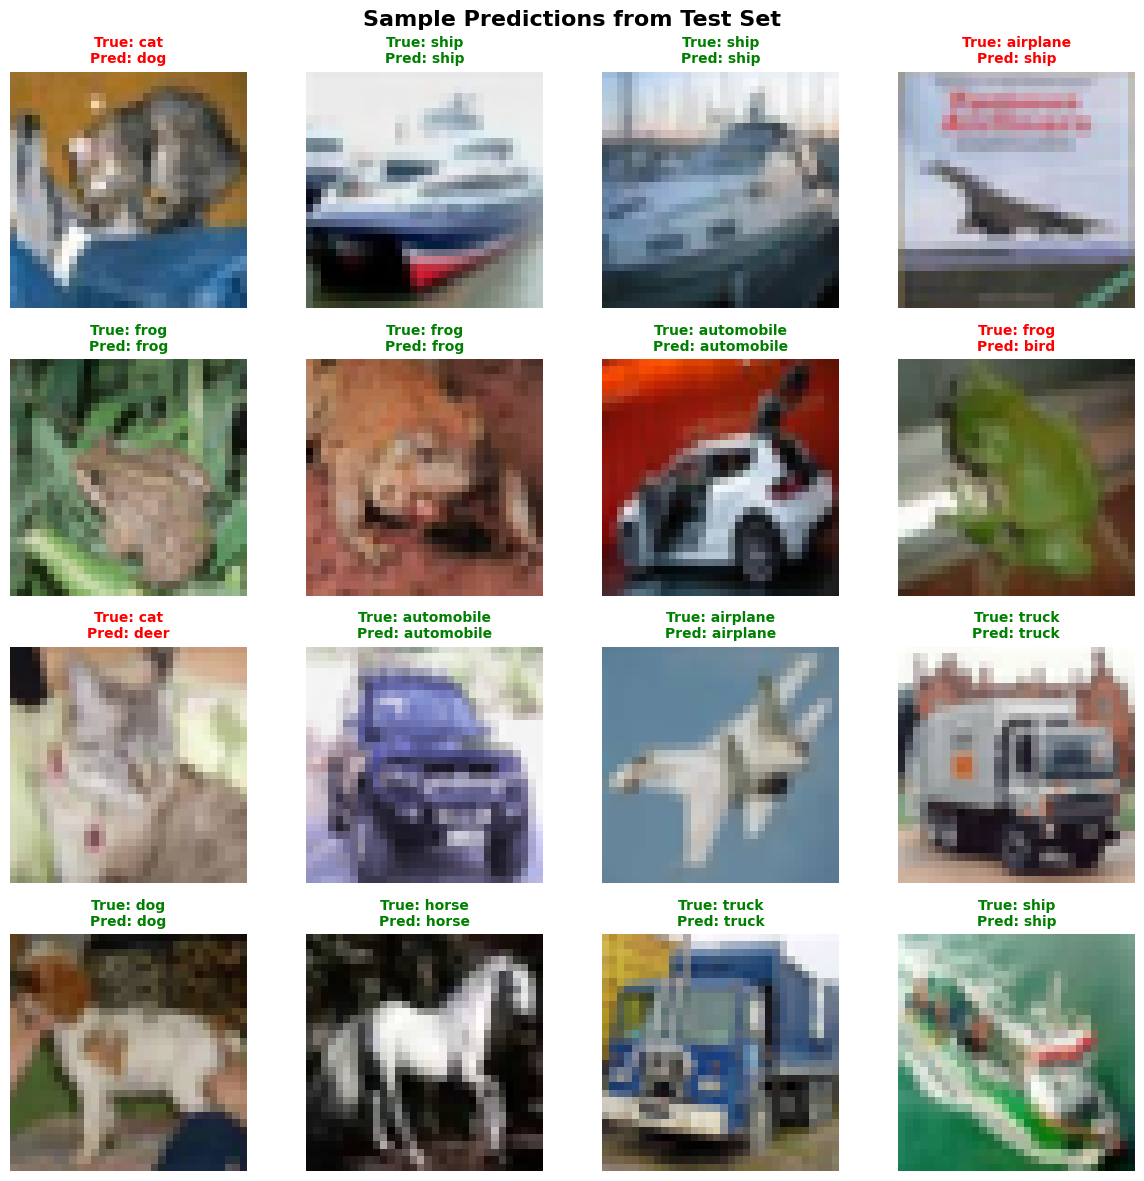

In [16]:
# Visualize some predictions
def show_predictions(model, testloader, device, num_images=16):
    model.eval()

    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    # Move to CPU for plotting
    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    # Denormalize images for display
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)

    # Plot
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Sample Predictions from Test Set', fontsize=16, fontweight='bold')

    for idx, ax in enumerate(axes.flat):
        if idx < num_images:
            img = images[idx].permute(1, 2, 0).numpy()
            ax.imshow(img)

            true_label = classes[labels[idx]]
            pred_label = classes[predicted[idx]]

            # Color: green if correct, red if wrong
            color = 'green' if labels[idx] == predicted[idx] else 'red'
            ax.set_title(f'True: {true_label}\nPred: {pred_label}',
                        color=color, fontweight='bold', fontsize=10)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()

show_predictions(model, testloader, device)